In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%%capture
!unzip '/content/drive/MyDrive/Colab Notebooks/ITI/CV project/Dataset.zip' 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

from warnings import filterwarnings
filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization,Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop,SGD,Adam

## Data Generator Class

Developed a custom Generator to suit the file structure in the dataset.

In [ ]:
from keras.utils import Sequence, to_categorical

In [ ]:
class DataGenerator(Sequence):
  'Generates data for Keras'
  
  def __init__(self, list_IDs, labels, batch_size=32, dim=(300,300,3), n_channels=3,
               shuffle=True, categorical=False, n_classes = None):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.categorical = categorical
    self.on_epoch_end()


  def on_epoch_end(self):
    # print('on_epoch_end')
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, indexes):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    # print('on_epoch_end')
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    labels_temp = [self.labels[k] for k in indexes]

    # Generate data
    for i, path in enumerate(list_IDs_temp):
      # print(path)
      # Store sample
      img = cv2.imread(path, cv2.IMREAD_COLOR)
      img = cv2.resize(img,(self.dim[0], self.dim[1]))
      img = img /255

      X[i,] = img
      # Store class
      y[i] = labels_temp[i]
      # print(y[i], path)

    return X, y

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    # list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(indexes)

    if self.categorical:
      return X, to_categorical(y, num_classes=self.n_classes)
    return X, y


  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

## Visualize image

In [ ]:
img = cv2.imread('/content/Dataset/Brain scans/Tumor/TRAIN/y105.jpg', cv2.IMREAD_GRAYSCALE)
img = np.expand_dims(img, axis=2)
img.shape

(446, 450, 1)

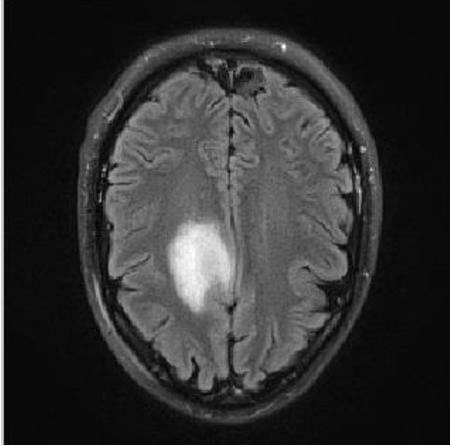

In [ ]:
cv2_imshow(img)

## Generate data

In [ ]:
def get_files_paths(list_path):
  res = []
  for path in list_path:
    res += [os.path.join(path, f) for f in os.listdir(path) if 'mask' not in f]
  return res

# Brain tumor vs no tumor model (2nd stage classification)

### Train Generator

In [ ]:
train_brain_tumor_sub = ['/content/Dataset/Brain scans/Tumor/TRAIN']
train_brain_notumor_sub = ['/content/Dataset/Brain scans/No tumor/Train']

In [ ]:
a = get_files_paths(train_brain_tumor_sub)
b = get_files_paths(train_brain_notumor_sub)
train_labels = [0]*len(a) + [1]*len(b)
train_list_IDs = a + b

In [ ]:
print(len(a), len(b))

500 501


In [ ]:
train_list_IDs[0]

'/content/Dataset/Brain scans/Tumor/TRAIN/y12.jpg'

In [ ]:
len(train_list_IDs)

1001

### Validation Generator

In [ ]:
test_brain_tumor_sub = ['/content/Dataset/Brain scans/Tumor/TEST']
test_brain_notumor_sub = ['/content/Dataset/Brain scans/No tumor/Test']

In [ ]:
c = get_files_paths(test_brain_tumor_sub)
d = get_files_paths(test_brain_notumor_sub)
test_labels = [0]*len(c) + [1]*len(d)
test_list_IDs = c + d

In [ ]:
print(len(c), len(d))

100 100


### train test

In [ ]:
np.random.shuffle(train_list_IDs)
train_val_size = len(train_list_IDs)
# val_size = int(0.15 * train_val_size)
train_size = int(0.85 * train_val_size)

In [ ]:
train_generator = DataGenerator(train_list_IDs[:train_size], train_labels[:train_size], batch_size = 32, dim=(256, 256))
validation_generator = DataGenerator(train_list_IDs[train_size:], train_labels[train_size:], batch_size = 32, dim=(256, 256))

test_generator = DataGenerator(test_list_IDs, test_labels, batch_size = 32, dim=(256, 256))

## Baseline model (CNN)
Without Augmentation

In [ ]:
input_shape = (256, 256, 3)

In [ ]:
model = Sequential()

model.add(Conv2D(128, (2,2),activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, (2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 128)     1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

In [ ]:
model.evaluate(test_generator)

### train validation

In [ ]:
train_generator = DataGenerator(train_list_IDs, train_labels, batch_size = 32, dim=(256, 256))
validation_generator = DataGenerator(test_list_IDs, test_labels, batch_size = 32, dim=(256, 256))

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/ITI/BestModel_2.h5')

In [ ]:
model = Sequential()

model.add(Conv2D(128, (2,2),activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, (2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 128)     1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)